In [2]:
from DoEAssessment import directionOfEffect
from functions import discrepancifier
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import (
    StructType,
    StructField,
    DoubleType,
    DecimalType,
    StringType,
    IntegerType,
    FloatType,
)

spark = SparkSession.builder.getOrCreate()

spark session created at 2024-10-18 15:37:20.693606
Analysis started on 2024-10-18 at  2024-10-18 15:37:20.693606


24/10/18 15:37:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


#### Load evidences, target and disease files

In [3]:
platform_v = "24.09"
evidences = (
    spark.read.parquet(
        f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/evidence"
    )
    .filter(
        F.col("datasourceId").isin(
            [
                "ot_genetics_portal",
                "gene_burden",
                "eva",
                "eva_somatic",
                "gene2phenotype",
                "orphanet",
                "cancer_gene_census",
                "intogen",
                "impc",
                "chembl",
            ]
        )
    )
    .persist()
)

disease_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/diseases/"
)
diseases = spark.read.parquet(disease_path)

target_path = (
    f"gs://open-targets-data-releases/{platform_v}/output/etl/parquet/targets/"
)
target = spark.read.parquet(target_path)

#### Run DoE assessment and discrepancy function

In [4]:
assessed_evidences = (
    directionOfEffect(evidences, platform_v)
    .filter(F.col("homogenized") != "noEvaluable")
    .withColumn(
        "datasources",
        F.collect_set("datasourceId").over(Window.partitionBy("targetId", "diseaseId")),
    )
    .withColumn(
        "maxClinPhase",
        F.max("clinicalPhase").over(Window.partitionBy("targetId", "diseaseId")),
    )
)
coherency_assessed = discrepancifier(
    assessed_evidences.withColumn(
        "arrayDiseaseFromSource",
        F.collect_set(F.col("diseaseFromSource")).over(
            Window.partitionBy("targetId", "diseaseId")
        ),
    )
    .groupBy(
        "targetId", "diseaseId", "datasources", "maxClinPhase", "arrayDiseaseFromSource"
    )
    .pivot("homogenized")
    .count()
).persist()

### We want to have a dataset with multiple annotations at the level of target-disease associations. The following are the datasets considered as interesting to have a comprehensive view of the associations

#### Dataset where datasources are collected per DoE assessment

In [18]:
coherency_assessed_datasourcesPerDoE = discrepancifier(
    assessed_evidences.withColumn(
        "arrayDiseaseFromSource",
        F.collect_set(F.col("diseaseFromSource")).over(
            Window.partitionBy("targetId", "diseaseId")
        ),
    )
    .groupBy(
        "targetId", "diseaseId", "datasources", "maxClinPhase", "arrayDiseaseFromSource"
    )
    .pivot("homogenized")
    .agg(F.collect_set(F.col("datasourceId")))
).selectExpr(
    "targetId",
    "diseaseId",
    "GoF_protect as ds_GoF_protect",
    "GoF_risk as ds_GoF_risk",
    "LoF_protect as ds_LoF_protect",
    "LoF_risk as ds_LoF_risk",
)

24/10/18 15:49:49 WARN CacheManager: Asked to cache already cached data.


#### Dataset to annotate whether genetics (no chembl datasource) is in agreement

In [6]:
assessed_evidences_genetics = (
    directionOfEffect(evidences, platform_v)
    .filter(F.col("homogenized") != "noEvaluable")
    .filter(F.col("datasourceId") != "chembl")
    .withColumn(
        "datasources",
        F.collect_set("datasourceId").over(Window.partitionBy("targetId", "diseaseId")),
    )
    .withColumn(
        "maxClinPhase",
        F.max("clinicalPhase").over(Window.partitionBy("targetId", "diseaseId")),
    )
)
coherency_assessed_genetics = (
    discrepancifier(
        assessed_evidences_genetics.withColumn(
            "arrayDiseaseFromSource",
            F.collect_set(F.col("diseaseFromSource")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy(
            "targetId",
            "diseaseId",
            "datasources",
            "maxClinPhase",
            "arrayDiseaseFromSource",
        )
        .pivot("homogenized")
        .count()
    )
    .withColumn(
        "geneticsAgreeDiagonal",
        F.when(F.col("coherencyDiagonal") == "coherent", F.lit("yes")).otherwise(
            F.lit("no")
        ),
    )
    .withColumn(
        "geneticsAgreeOneCell",
        F.when(F.col("coherencyOneCell") == "coherent", F.lit("yes")).otherwise(
            F.lit("no")
        ),
    )
    .select("targetId", "diseaseId", "geneticsAgreeDiagonal", "geneticsAgreeOneCell")
    .persist()
)

24/10/18 15:40:14 WARN CacheManager: Asked to cache already cached data.


#### Dataset to annnotate whether human genetics (no chembl nor IMPC datasource) is in agreement

In [7]:
assessed_evidences_genetics_noIMPC = (
    directionOfEffect(evidences, platform_v)
    .filter(F.col("homogenized") != "noEvaluable")
    .filter(F.col("datasourceId") != "chembl")
    .filter(F.col("datasourceId") != "IMPC")
    .withColumn(
        "datasources",
        F.collect_set("datasourceId").over(Window.partitionBy("targetId", "diseaseId")),
    )
    .withColumn(
        "maxClinPhase",
        F.max("clinicalPhase").over(Window.partitionBy("targetId", "diseaseId")),
    )
)
coherency_assessed_genetics_noIMPC = (
    discrepancifier(
        assessed_evidences_genetics_noIMPC.withColumn(
            "arrayDiseaseFromSource",
            F.collect_set(F.col("diseaseFromSource")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy(
            "targetId",
            "diseaseId",
            "datasources",
            "maxClinPhase",
            "arrayDiseaseFromSource",
        )
        .pivot("homogenized")
        .count()
    )
    .withColumn(
        "geneticsAgreeDiagonal_noIMPC",
        F.when(F.col("coherencyDiagonal") == "coherent", F.lit("yes")).otherwise(
            F.lit("no")
        ),
    )
    .withColumn(
        "geneticsAgreeOneCell_noIMPC",
        F.when(F.col("coherencyOneCell") == "coherent", F.lit("yes")).otherwise(
            F.lit("no")
        ),
    )
    .select(
        "targetId",
        "diseaseId",
        "geneticsAgreeDiagonal_noIMPC",
        "geneticsAgreeOneCell_noIMPC",
    )
    .persist()
)

24/10/18 15:40:22 WARN CacheManager: Asked to cache already cached data.


#### Dataset to annotate whether there are different diseases from source informing distinct DoE assessments

In [8]:
coherency_assessed_diseaseFromSource = discrepancifier(
    assessed_evidences.withColumn(
        "arrayDiseaseFromSource",
        F.collect_set(F.col("diseaseFromSource")).over(
            Window.partitionBy("targetId", "diseaseId")
        ),
    )
    .groupBy("targetId", "diseaseId", "datasources", "maxClinPhase")
    .pivot("homogenized")
    .agg(F.collect_set(F.col("diseaseFromSource")))
).persist()

#### Now we will make an assessment to evaluate whether the disease from source in the disparities (and coherencies) are the same or not

columns_to_rename = ["GoF_protect", "GoF_risk", "LoF_protect", "LoF_risk"]

# Rename all the specified columns by adding 'disSource' to their names
for col in columns_to_rename:
    coherency_assessed_diseaseFromSource = (
        coherency_assessed_diseaseFromSource.withColumnRenamed(col, f"{col}_disSource")
    )

# After renaming, select the desired columns
coherency_assessed_diseaseFromSource_new = coherency_assessed_diseaseFromSource.select(
    "targetId",
    "diseaseId",
    "GoF_protect_disSource",
    "LoF_protect_disSource",
    "GoF_risk_disSource",
    "LoF_risk_disSource",
)

coherency_assessed_diseaseFromSource_new2 = (
    coherency_assessed_diseaseFromSource_new.withColumn(
        "GP_LR",
        F.when(
            (
                (
                    (F.size(F.col("GoF_protect_disSource")) > 0)
                    & (F.size(F.col("LoF_risk_disSource")) > 0)
                )
                | (
                    (F.size(F.col("GoF_protect_disSource")) > 0)
                    | (F.size(F.col("LoF_risk_disSource")) > 0)
                )
            )
            & (
                (
                    (F.size(F.col("LoF_protect_disSource")) > 0)
                    | (F.size(F.col("GoF_risk_disSource")) > 0)
                )
                | (
                    (F.size(F.col("LoF_protect_disSource")) > 0)
                    & (F.size(F.col("GoF_risk_disSource")) > 0)
                )
            ),
            F.lit("dispar1"),
        )
        .when(
            (
                (
                    (F.size(F.col("GoF_risk_disSource")) > 0)
                    & (F.size(F.col("LoF_protect_disSource")) > 0)
                )
                | (
                    (F.size(F.col("GoF_risk_disSource")) > 0)
                    | (F.size(F.col("LoF_protect_disSource")) > 0)
                )
            )
            & (
                (
                    (F.size(F.col("GoF_protect_disSource")) > 0)
                    | (F.size(F.col("LoF_risk_disSource")) > 0)
                )
                | (
                    (F.size(F.col("GoF_protect_disSource")) > 0)
                    & (F.size(F.col("LoF_risk_disSource")) > 0)
                )
            ),
            F.lit("dispar2"),
        )
        .otherwise(F.lit("coherent")),
    )
    .withColumn(
        "array1",
        F.flatten(
            F.array_distinct(
                F.array(F.col("GoF_protect_disSource"), F.col("LoF_risk_disSource"))
            )
        ),
    )
    .withColumn(
        "array2",
        F.flatten(
            F.array_distinct(
                F.array(F.col("LoF_protect_disSource"), F.col("GoF_risk_disSource"))
            )
        ),
    )
    .withColumn(
        "array1Dispar",
        F.flatten(
            F.array_distinct(
                F.array(F.col("LoF_protect_disSource"), F.col("GoF_risk_disSource"))
            )
        ),
    )
    .withColumn(
        "array2Dispar",
        F.flatten(
            F.array_distinct(
                F.array(F.col("GoF_protect_disSource"), F.col("LoF_risk_disSource"))
            )
        ),
    )
).withColumn(
    "diseaseSource",  #### Need to check this. Labelling as diferent when having just one disease name
    F.when(
        (
            (F.size(F.col("array1")))
            == (F.size(F.array_intersect(F.col("array1"), F.col("array1Dispar"))))
        )
        & (
            (F.size(F.col("array1Dispar")))
            == (F.size(F.array_intersect(F.col("array1"), F.col("array1Dispar"))))
        ),
        F.lit("same"),
    ).otherwise("diferent"),
)

#### Dataset to annotate the most severe therapeutic area of each disease

In [9]:
complementary = (
    assessed_evidences.groupBy("targetId", "diseaseId")
    .pivot("homogenized")
    .agg(F.collect_set("datasourceId"))
)
taDf = spark.createDataFrame(
    data=[
        ("MONDO_0045024", "cell proliferation disorder", "Oncology"),
        ("EFO_0005741", "infectious disease", "Other"),
        ("OTAR_0000014", "pregnancy or perinatal disease", "Other"),
        ("EFO_0005932", "animal disease", "Other"),
        ("MONDO_0024458", "disease of visual system", "Other"),
        ("EFO_0000319", "cardiovascular disease", "Other"),
        ("EFO_0009605", "pancreas disease", "Other"),
        ("EFO_0010282", "gastrointestinal disease", "Other"),
        ("OTAR_0000017", "reproductive system or breast disease", "Other"),
        ("EFO_0010285", "integumentary system disease", "Other"),
        ("EFO_0001379", "endocrine system disease", "Other"),
        ("OTAR_0000010", "respiratory or thoracic disease", "Other"),
        ("EFO_0009690", "urinary system disease", "Other"),
        ("OTAR_0000006", "musculoskeletal or connective tissue disease", "Other"),
        ("MONDO_0021205", "disease of ear", "Other"),
        ("EFO_0000540", "immune system disease", "Other"),
        ("EFO_0005803", "hematologic disease", "Other"),
        ("EFO_0000618", "nervous system disease", "Other"),
        ("MONDO_0002025", "psychiatric disorder", "Other"),
        ("MONDO_0024297", "nutritional or metabolic disease", "Other"),
        ("OTAR_0000018", "genetic, familial or congenital disease", "Other"),
        ("OTAR_0000009", "injury, poisoning or other complication", "Other"),
        ("EFO_0000651", "phenotype", "Other"),
        ("EFO_0001444", "measurement", "Other"),
        ("GO_0008150", "biological process", "Other"),
    ],
    schema=StructType(
        [
            StructField("taId", StringType(), True),
            StructField("taLabel", StringType(), True),
            StructField("taLabelSimple", StringType(), True),
        ]
    ),
).withColumn("taRank", F.monotonically_increasing_id())

wByDisease = Window.partitionBy("diseaseId")

complete = (
    coherency_assessed.join(
        diseases.withColumn("taId", F.explode("therapeuticAreas"))
        .select(F.col("id").alias("diseaseId"), "taId", "name")
        .join(taDf, on="taId", how="left")
        .withColumn("minRank", F.min("taRank").over(wByDisease))
        .filter(F.col("taRank") == F.col("minRank"))
        .drop("taRank", "minRank"),
        on="diseaseId",
        how="left",
    )
    .select(
        "targetId",
        "diseaseId",
        "arrayDiseaseFromSource",
        "name",
        "GoF_protect",
        "GoF_risk",
        "LoF_protect",
        "LoF_risk",
        "coherencyDiagonal",
        "coherencyOneCell",
        "datasources",
        "maxClinPhase",
        "taLabel",
        "taLabelSimple",
    )
    .filter(
        (F.col("coherencyDiagonal") == "dispar")
        | (F.col("coherencyOneCell") == "dispar")
    )
    .join(
        target.selectExpr("id as targetId", "approvedSymbol"), on="targetId", how="left"
    )
    .withColumn(
        "linkOT",
        F.concat(
            F.lit("https://platform.opentargets.org/evidence/"),
            F.col("targetId"),
            F.lit("/"),
            F.col("diseaseId"),  # Column containing "EFO_0009188"
        ),
    )
    .persist()
)

#### Join previous datasets (containig annotations) with the main

In [19]:
complete_whole = (
    complete.join(
        coherency_assessed_datasourcesPerDoE, on=["targetId", "diseaseId"], how="left"
    )
    .join(coherency_assessed_genetics, on=["targetId", "diseaseId"], how="left")
    .join(coherency_assessed_genetics_noIMPC, on=["targetId", "diseaseId"], how="left")
).persist()

### Join with the dataset with manual annotations

In [10]:
### manual annotations dataset:
annotations = spark.read.csv(
    "gs://ot-team/jroldan/analysis/jroldan_analysis_20240516_subsetInterestingSpace_20241016.csv",
    header=True,
    inferSchema=True,
).select(
    "targetId",
    "diseaseId",
    "_c15",
    "comment",
    "type",
    "data type",
    "is_indication_the_main_disease?",
    "is_the_causality_target-disease_the_reason_of_the_drug?",
    "New_Coherency_Diagonal?",
    "New_Coherency_One_Cell?",
    "Potential_Safety",
)

#### Join manual annotations and diseases from Source with the complete whole 

In [20]:
complete_whole_ready = complete_whole.join(
    annotations, on=["targetId", "diseaseId"], how="left"
).join(
    coherency_assessed_diseaseFromSource_new2, on=["targetId", "diseaseId"], how="left"
)

### Check number of measurement and phenotypes with discrepancies where disease from source is different:

In [112]:
complete_whole_ready.filter(F.col("coherencyDiagonal") == "dispar").groupBy(
    "taName"
).pivot("diseaseSource").count().sort(F.col("same").desc()).show(truncate=False)

+--------------------------------------------------------------------------------------------------+--------+----+
|taName                                                                                            |diferent|same|
+--------------------------------------------------------------------------------------------------+--------+----+
|[measurement]                                                                                     |3766    |1989|
|[cell proliferation disorder, reproductive system or breast disease]                              |98      |57  |
|[psychiatric disorder, nervous system disease]                                                    |262     |45  |
|[cell proliferation disorder, endocrine system disease, reproductive system or breast disease]    |48      |34  |
|[cardiovascular disease]                                                                          |175     |32  |
|[cell proliferation disorder, gastrointestinal disease]                        

#### Print dataset to share with partners

In [23]:
complete_whole_ready.printSchema()

root
 |-- targetId: string (nullable = true)
 |-- diseaseId: string (nullable = true)
 |-- arrayDiseaseFromSource: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- name: string (nullable = true)
 |-- GoF_protect: long (nullable = true)
 |-- GoF_risk: long (nullable = true)
 |-- LoF_protect: long (nullable = true)
 |-- LoF_risk: long (nullable = true)
 |-- coherencyDiagonal: string (nullable = true)
 |-- coherencyOneCell: string (nullable = true)
 |-- datasources: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- maxClinPhase: double (nullable = true)
 |-- taLabel: string (nullable = true)
 |-- taLabelSimple: string (nullable = true)
 |-- approvedSymbol: string (nullable = true)
 |-- linkOT: string (nullable = true)
 |-- ds_GoF_protect: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- ds_GoF_risk: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- ds_LoF_protect: array (nul

In [26]:
complete_whole_ready.filter(F.col("coherencyDiagonal") == "dispar").selectExpr(
    "targetId",
    "approvedSymbol",
    "diseaseId",
    "name",
    "GoF_protect",
    "GoF_risk",
    "LoF_protect",
    "LoF_risk",
    "coherencyDiagonal",
    "datasources",
    "maxClinPhase",
    "taLabel",
    "taLabelSimple",
    "linkOT",
    "ds_GoF_protect",
    "ds_GoF_risk",
    "ds_LoF_protect",
    "ds_LoF_risk",
    "geneticsAgreeDiagonal",
    "geneticsAgreeDiagonal_noIMPC",
    "GoF_protect_disSource as disSource_GoF_protect",
    "LoF_protect_disSource as disSource_LoF_protect",
    "GoF_risk_disSource as disSource_GoF_risk",
    "LoF_risk_disSource as disSource_LoF_risk",
    "diseaseSource as diferent_disSource",
).toPandas().to_csv(
    "gs://ot-team/jroldan/analysis/20241018_diagonalDiscrepanciesDoE.csv"
)

#### Among measurement and phenotypes, 2/3 are discrepancies have different disease from source in giving different DoE

In [104]:
complete_whole_ready.filter(
    F.size(
        F.array_intersect(
            F.col("taName"), F.array(F.lit("measurement"), F.lit("phenotype"))
        )
    )
    > 0
).filter(F.col("coherencyDiagonal") == "dispar").groupBy("diseaseSource").count().show()

+-------------+-----+
|diseaseSource|count|
+-------------+-----+
|         same| 2019|
|     diferent| 4059|
+-------------+-----+



#### Counts of associations per N of evidences

In [36]:
coherency_assessed.withColumn(
    "totalEvidences",
    F.coalesce(F.col("GoF_protect"), F.lit(0))
    + F.coalesce(F.col("GoF_risk"), F.lit(0))
    + F.coalesce(F.col("LoF_protect"), F.lit(0))
    + F.coalesce(F.col("LoF_risk"), F.lit(0)),
).withColumn(
    "greaterThan1",
    F.when(F.col("totalEvidences") > 1, F.lit("greaterThan1")).otherwise(F.lit(1)),
).groupBy(
    "greaterThan1", "coherencyOneCell"
).count().show()

+------------+----------------+------+
|greaterThan1|coherencyOneCell| count|
+------------+----------------+------+
|           1|        coherent|588232|
|greaterThan1|          dispar| 15885|
|greaterThan1|        coherent|261699|
+------------+----------------+------+



#### Discrepancies per therapeutic Area

In [ ]:
import seaborn as sns

#### Numbers of discrepancies regarding diagonal criteria

In [74]:
toBarPlot = (
    complete_whole_ready.filter(F.col("coherencyDiagonal") == "dispar")
    .groupBy("taLabel")
    .count()
    .sort(F.col("count").desc())
    .limit(10)
    .toPandas()
)

<AxesSubplot:xlabel='count', ylabel='taLabel'>

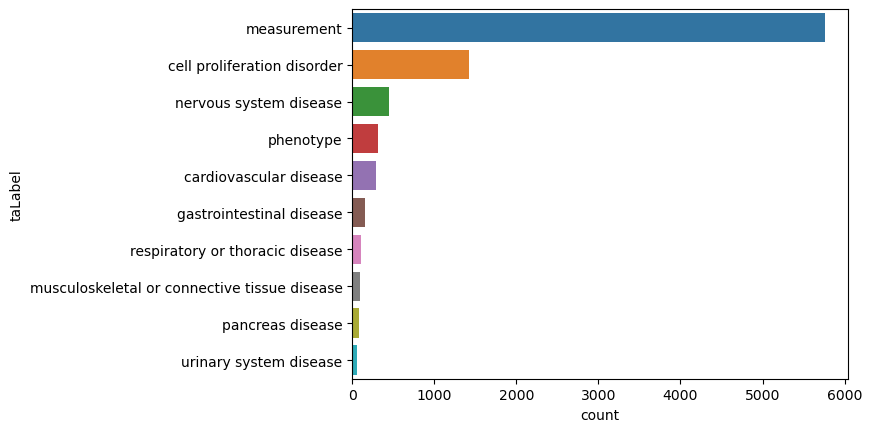

In [75]:
sns.barplot(toBarPlot, x="count", y="taLabel", errorbar=None, orient="h")

### Bring diseases from measurements

In [96]:
toPlotMeasurements = (
    complete_whole_ready.filter(F.col("taLabel") == "measurement")
    .groupBy(
        "name",
        "arrayDiseaseFromSource",
        # "GP_LR",
        # "diseaseSource"
    )
    .count()
    .sort(F.col("count").desc())
    # .withColumn("difSources", F.size("arrayDiseaseFromSource"))
    .limit(20)
    .toPandas()
)

<AxesSubplot:xlabel='count', ylabel='name'>

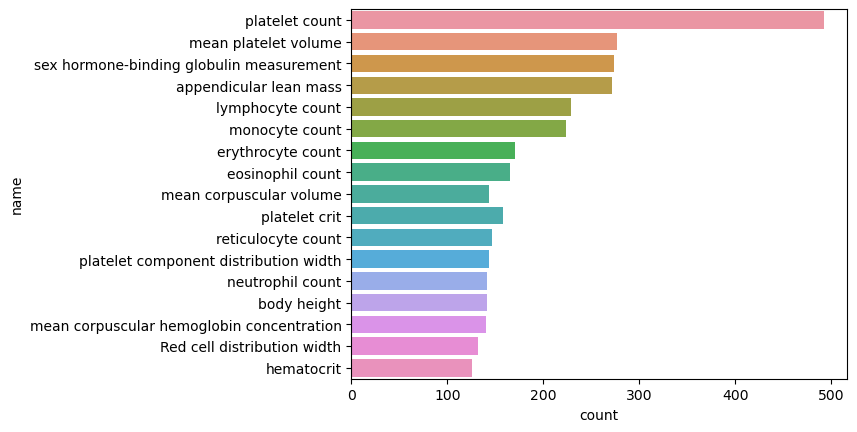

In [97]:
sns.barplot(toPlotMeasurements, x="count", y="name", errorbar=None, orient="h")

In [77]:
### Genes type in measurements
complete_whole_ready.filter(F.col("taLabel") == "measurement").groupBy(
    "approvedSymbol"
).count().sort(F.col("count").desc()).show()

+--------------+-----+
|approvedSymbol|count|
+--------------+-----+
|          APOE|   30|
|           ABO|   24|
|         SH2B3|   24|
|         FADS1|   23|
|          LIPC|   22|
|        PIEZO1|   22|
|          LEPR|   21|
|         FADS2|   18|
|        JMJD1C|   16|
|          TET2|   16|
|       TMEM258|   16|
|        IFITM2|   16|
|         CEBPA|   15|
|      SLC25A37|   15|
|         PPARG|   14|
|         APOC1|   14|
|        UBXN2A|   14|
|          FEN1|   14|
|          MYRF|   14|
|        LEPROT|   13|
+--------------+-----+
only showing top 20 rows



### Examples of 2/3 different diseases from source

In [120]:
#### Example 1 - example of 2 datasources giving different

complete_whole_ready.filter(
    (F.col("targetId") == "ENSG00000112079") & (F.col("diseaseId") == "EFO_0004309")
).show(vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------
 targetId                                                | ENSG00000112079                                                       
 diseaseId                                               | EFO_0004309                                                           
 arrayDiseaseFromSource                                  | [Platelet count, 30080#Platelet count]                                
 name                                                    | platelet count                                                        
 GoF_protect                                             | null                                                                  
 GoF_risk                                                | 1                                                                     
 LoF_protect                                             | 1                              

In [122]:
### Example 2

complete_whole_ready.filter(
    (F.col("targetId") == "ENSG00000158552") & (F.col("diseaseId") == "EFO_0007993")
).show(vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------
 targetId                                                | ENSG00000158552                                                       
 diseaseId                                               | EFO_0007993                                                           
 arrayDiseaseFromSource                                  | [Lymphocyte percentage, Lymphocyte percentage of white cells]         
 name                                                    | lymphocyte percentage of leukocytes                                   
 GoF_protect                                             | 1                                                                     
 GoF_risk                                                | null                                                                  
 LoF_protect                                             | 2                              

In [123]:
### Example 3

complete_whole_ready.filter(
    (F.col("targetId") == "ENSG00000107201") & (F.col("diseaseId") == "EFO_0004509")
).show(vertical=True, truncate=False)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------
 targetId                                                | ENSG00000107201                                                                     
 diseaseId                                               | EFO_0004509                                                                         
 arrayDiseaseFromSource                                  | [Hemoglobin levels, Hemoglobin concentration, Hemoglobin]                           
 name                                                    | hemoglobin measurement                                                              
 GoF_protect                                             | 1                                                                                   
 GoF_risk                                                | 3                                                                            

In [128]:
### Example 4

complete_whole_ready.filter(
    (F.col("targetId") == "ENSG00000169231") & (F.col("diseaseId") == "EFO_0004980")
).show(vertical=True, truncate=False)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------------------------
 targetId                                                | ENSG00000169231                                                                                              
 diseaseId                                               | EFO_0004980                                                                                                  
 arrayDiseaseFromSource                                  | [Appendicular fat free mass index adjusted for body mass index (AFFMIadjBMI) female, Appendicular lean mass] 
 name                                                    | appendicular lean mass                                                                                       
 GoF_protect                                             | 1                                                                                               

In [129]:
### Example 5

complete_whole_ready.filter(
    (F.col("targetId") == "ENSG00000183579") & (F.col("diseaseId") == "EFO_0007824")
).show(vertical=True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------
 targetId                                                | ENSG00000183579                                                       
 diseaseId                                               | EFO_0007824                                                           
 arrayDiseaseFromSource                                  | [Pattern 1 | hair/balding pattern, Pattern 4 | hair/balding pattern]  
 name                                                    | hair shape measurement                                                
 GoF_protect                                             | null                                                                  
 GoF_risk                                                | null                                                                  
 LoF_protect                                             | 1                              

In [17]:
#### example 6
complete_whole_ready.filter(
    (F.col("targetId") == "ENSG00000107902")
    & (F.col("diseaseId") == "EFO_0004995")
    & (F.col("taLabel") == "measurement")
    & (F.col("GP_LR") == "dispar1")
    & (F.col("diseaseSource") == "diferent")
).select(
    "approvedSymbol",
    "name",
    "GoF_protect_disSource",
    "LoF_protect_disSource",
    "GoF_risk_disSource",
    "LoF_risk_disSource",
).show(
    truncate=False
)

+--------------+--------------+-----------------------------------------------+-------------------------------------------------------+---------------------------------------------------------------------------------+------------------+
|approvedSymbol|name          |GoF_protect_disSource                          |LoF_protect_disSource                                  |GoF_risk_disSource                                                               |LoF_risk_disSource|
+--------------+--------------+-----------------------------------------------+-------------------------------------------------------+---------------------------------------------------------------------------------+------------------+
|LHPP          |lean body mass|[Trunk fat-free mass, Arm fat-free mass (left)]|[Arm predicted mass (right), Arm fat-free mass (right)]|[Leg predicted mass (right), Leg predicted mass (left), Leg fat-free mass (left)]|[]                |
+--------------+--------------+---------------------

#### Print all T-D with different disease from source giving different DoE assessment (discrepancies)

In [ ]:
complete_whole_ready.filter(
    (F.col("taLabel") == "measurement")
    & (F.col("GP_LR") == "dispar1")
    & (F.col("diseaseSource") == "diferent")
).select("targetId", "diseaseId", "name", "arrayDiseaseFromSource").sort(
    F.col("diseaseId").desc()
).show(
    5000, truncate=False
)

#### Oncoogy / Non oncology of the discrepancies out of measurements and phenotypes

In [1]:
complete_whole_ready.filter(
    ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") != "dispar")
).groupBy("taLabelSimple").count().show()

NameError: name 'complete_whole_ready' is not defined

### How many of them (no measurement and no phenotype) have chembl + other datasource

In [27]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) > 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).count()

907

#### Oncology VS Non oncology for the ones in Drug VS Genetics

In [28]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) > 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).groupBy("taLabelSimple").count().show()

+-------------+-----+
|taLabelSimple|count|
+-------------+-----+
|        Other|  416|
|     Oncology|  491|
+-------------+-----+



In [37]:
#### print Drug VS Genetics
complete_whole_ready.filter(
    (F.size(F.col("datasources")) > 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).toPandas().to_csv("gs://ot-team/jroldan/analysis/20241017_DrugVSGenetics.csv")

In [66]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) > 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
    # & (F.col("taLabelSimple") == "Oncology")
).groupBy("taLabelSimple").count().show()

+-------------+-----+
|taLabelSimple|count|
+-------------+-----+
|        Other|  416|
|     Oncology|  491|
+-------------+-----+



In [67]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) > 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).groupBy("taLabelSimple").count().show()

+-------------+-----+
|taLabelSimple|count|
+-------------+-----+
|        Other|  416|
|     Oncology|  491|
+-------------+-----+



##### genes for Drugs VS genetics ONCOLOGY

<AxesSubplot:xlabel='count', ylabel='approvedSymbol'>

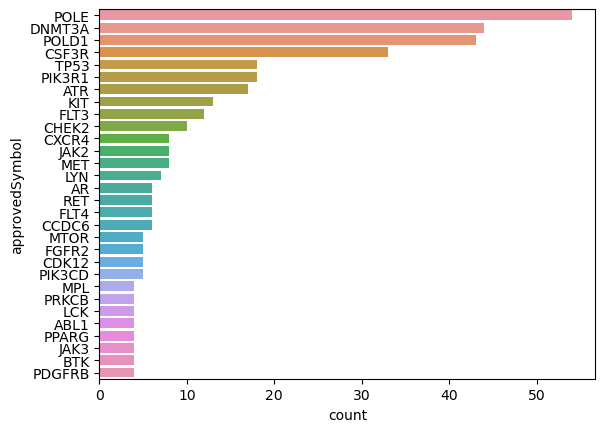

In [62]:
genes_DrugsGenOncology = (
    complete_whole_ready.filter(
        (F.size(F.col("datasources")) > 1)
        & (F.array_contains(F.col("datasources"), "chembl"))
        & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
        & (F.col("coherencyDiagonal") == "dispar")
        & (F.col("taLabelSimple") == "Oncology")
    )
    .groupBy("approvedSymbol")
    .count()
    .sort(F.col("count").desc())
    .limit(30)
    .toPandas()
)

sns.barplot(
    genes_DrugsGenOncology, x="count", y="approvedSymbol", errorbar=None, orient="h"
)

In [42]:
#### Generate dataset for upset plot
### Give a unique identifier to T-D pairs
### Explode datasources columns
### group by Unique ID and taLabelSimple and pivot datasources
complete_whole_ready.filter(
    (F.size(F.col("datasources")) > 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).withColumn("unique_id", F.monotonically_increasing_id()).withColumn(
    "datasource_expl", F.explode_outer(F.col("datasources"))
).groupBy(
    "unique_id", "taLabelSimple"
).pivot(
    "datasource_expl"
).count().fillna(
    0
).toPandas().to_csv(
    "gs://ot-team/jroldan/analysis/20241017_DrugVSGeneticsUpSetPlot.csv"
)

#### Genes for DRUGS VS GENETICS NON ONCOLOGY

<AxesSubplot:xlabel='count', ylabel='approvedSymbol'>

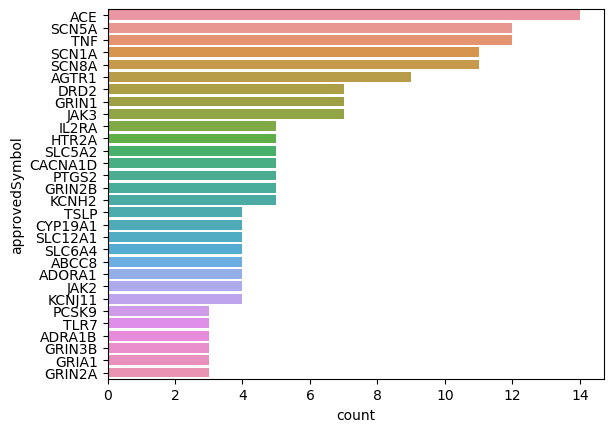

In [68]:
genes_DrugsGenNonOnco = (
    complete_whole_ready.filter(
        (F.size(F.col("datasources")) > 1)
        & (F.array_contains(F.col("datasources"), "chembl"))
        & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
        & (F.col("coherencyDiagonal") == "dispar")
        & (F.col("taLabelSimple") == "Other")
    )
    .groupBy("approvedSymbol")
    .count()
    .sort(F.col("count").desc())
    .limit(30)
    .toPandas()
)

sns.barplot(
    genes_DrugsGenNonOnco, x="count", y="approvedSymbol", errorbar=None, orient="h"
)

#### Numbers per Onco / Non onco in the group 

In [29]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) > 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyOneCell") == "dispar")
).groupBy("taLabelSimple").count().show()

+-------------+-----+
|taLabelSimple|count|
+-------------+-----+
|        Other|  622|
|     Oncology| 1708|
+-------------+-----+



#### Numbers for the group where the is OR chembl alone or just genetics
    -- This group is characterized by no genetics but genes seem to be problematic


In [30]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) == 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).groupBy("taLabelSimple").count().show()

+-------------+-----+
|taLabelSimple|count|
+-------------+-----+
|        Other|  701|
|     Oncology|  628|
+-------------+-----+



#### print the dataset of just drug discrepancies alone

In [45]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) == 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).toPandas().to_csv("gs://ot-team/jroldan/analysis/20241017_DrugsONLY.csv")

<AxesSubplot:xlabel='count', ylabel='taLabel'>

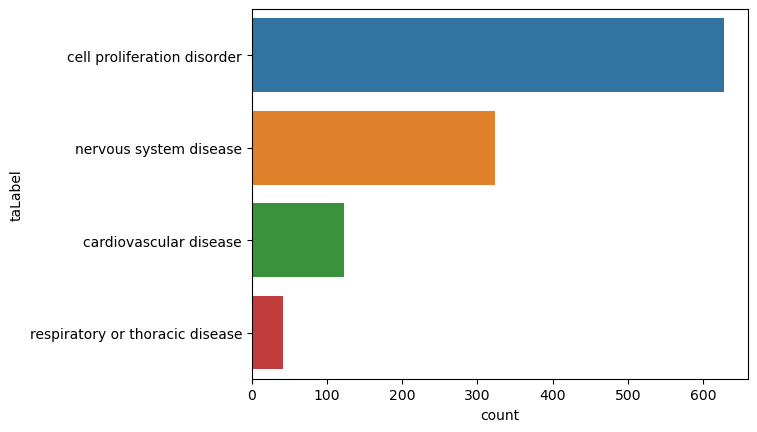

In [72]:
taLabelDrugsOnly = (
    complete_whole_ready.filter(
        (F.size(F.col("datasources")) == 1)
        & (F.array_contains(F.col("datasources"), "chembl"))
        & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
        & (F.col("coherencyDiagonal") == "dispar")
    )
    .groupBy("taLabel")
    .count()
    .sort(F.col("count").desc())
    .limit(4)
    .toPandas()
)


sns.barplot(taLabelDrugsOnly, x="count", y="taLabel", errorbar=None, orient="h")

#### Frequency of genes in Drugs Only subset

<AxesSubplot:xlabel='count', ylabel='approvedSymbol'>

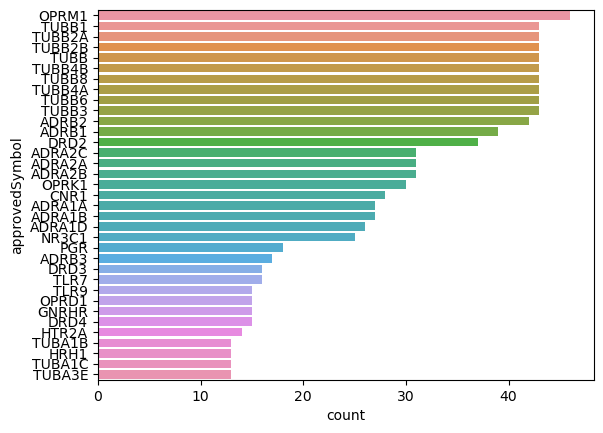

In [53]:
genesDrugsONLY = (
    complete_whole_ready.filter(
        (F.size(F.col("datasources")) == 1)
        & (F.array_contains(F.col("datasources"), "chembl"))
        & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
        & (F.col("coherencyDiagonal") == "dispar")
    )
    .groupBy("approvedSymbol")
    .count()
    .sort(F.col("count").desc())
    .limit(35)
    .toPandas()
)

sns.barplot(genesDrugsONLY, x="count", y="approvedSymbol", errorbar=None, orient="h")

#### N of T-D per TA in Drugs Only subset

<AxesSubplot:xlabel='count', ylabel='taLabelSimple'>

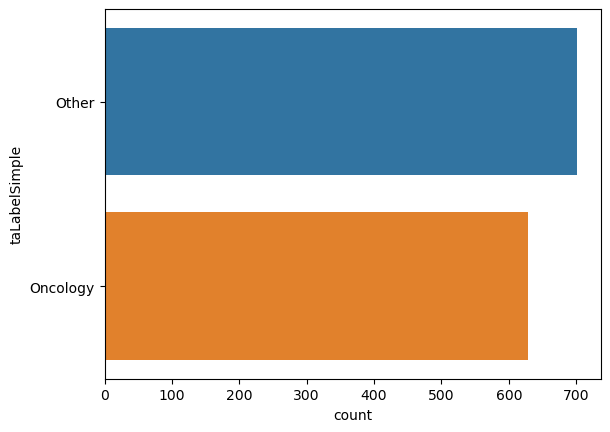

In [44]:
taDrugsOnly = (
    complete_whole_ready.filter(
        (F.size(F.col("datasources")) == 1)
        & (F.array_contains(F.col("datasources"), "chembl"))
        & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
        & (F.col("coherencyDiagonal") == "dispar")
    )
    .groupBy("taLabelSimple")
    .count()
    .toPandas()
)
sns.barplot(taDrugsOnly, x="count", y="taLabelSimple", errorbar=None, orient="h")

#### Genetics discrepancies (ONLY genetics, no drugs)

In [54]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) >= 1)
    & ~(F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).groupBy("taLabelSimple").count().show()

+-------------+-----+
|taLabelSimple|count|
+-------------+-----+
|        Other|  490|
|     Oncology|  306|
+-------------+-----+



#### N T-D per TA in Genetics ONLY subset

<AxesSubplot:xlabel='count', ylabel='taLabelSimple'>

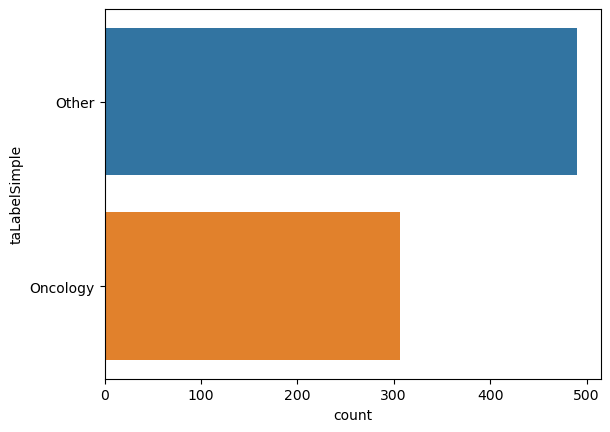

In [55]:
taGeneticsOnly = (
    complete_whole_ready.filter(
        (F.size(F.col("datasources")) >= 1)
        & ~(F.array_contains(F.col("datasources"), "chembl"))
        & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
        & (F.col("coherencyDiagonal") == "dispar")
    )
    .groupBy("taLabelSimple")
    .count()
    .toPandas()
)
sns.barplot(taGeneticsOnly, x="count", y="taLabelSimple", errorbar=None, orient="h")

<AxesSubplot:xlabel='count', ylabel='approvedSymbol'>

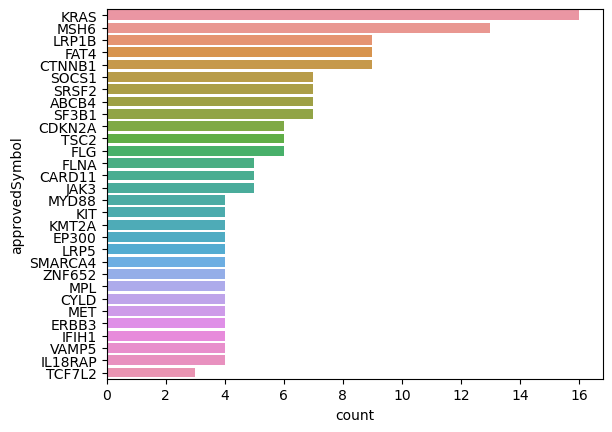

In [57]:
#### Genes
genesGeneticsOnly = (
    complete_whole_ready.filter(
        (F.size(F.col("datasources")) >= 1)
        & ~(F.array_contains(F.col("datasources"), "chembl"))
        & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
        & (F.col("coherencyDiagonal") == "dispar")
    )
    .groupBy("approvedSymbol")
    .count()
    .sort(F.col("count").desc())
    .limit(30)
    .toPandas()
)

sns.barplot(genesGeneticsOnly, x="count", y="approvedSymbol", errorbar=None, orient="h")

#### Print dataset for generating upset plot for genetics discrepancies 

In [58]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) >= 1)
    & ~(F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).count()

796

In [59]:
GeneticsOnlyUpSetPlot = (
    (
        complete_whole_ready.filter(
            (F.size(F.col("datasources")) >= 1)
            & ~(F.array_contains(F.col("datasources"), "chembl"))
            & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
            & (F.col("coherencyDiagonal") == "dispar")
        )
        .withColumn("unique_id", F.monotonically_increasing_id())
        .withColumn("datasource_expl", F.explode_outer(F.col("datasources")))
        .groupBy("unique_id", "taLabelSimple")
        .pivot("datasource_expl")
        .count()
        .fillna(0)
    )
    .toPandas()
    .to_csv("gs://ot-team/jroldan/analysis/20241017_OnlyGeneticsUpSetPlot.csv")
)

In [33]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) >= 1)
    & ~(F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).show()

+---------------+---------------+----------------------+--------------------+-----------+--------+-----------+--------+-----------------+----------------+--------------------+------------+--------------------+-------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+----------------------------+---------------------------+----+-------+----+-------------+-------------------------------+-------------------------------------------------------+-----------------------+-----------------------+----------------+---------------------+---------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+-------------+
|       targetId|      diseaseId|arrayDiseaseFromSource|                name|GoF_protect|GoF_risk|LoF_protect|LoF_risk|coherencyDiagonal|coherencyOneCell|         datasources|max

In [36]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) >= 1)
    & ~(F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).count()

796

In [32]:
complete_whole_ready.filter(
    (F.size(F.col("datasources")) >= 1)
    & ~(F.array_contains(F.col("datasources"), "chembl"))
    & ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") == "dispar")
).groupBy("taLabelSimple").count().show()

+-------------+-----+
|taLabelSimple|count|
+-------------+-----+
|        Other|  490|
|     Oncology|  306|
+-------------+-----+



#### Count how many are dispar in Diagonal

In [19]:
complete_whole_ready.filter(
    ~(F.col("taLabel").isin(["measurement", "phenotype"]))
    & (F.col("coherencyDiagonal") != "dispar")
).count()

1800

In [104]:
complete_whole_ready2.filter(
    (
        F.size(
            F.array_intersect(
                F.col("taName"), F.array(F.lit("measurement"), F.lit("phenotype"))
            )
        )
        > 1
    )
).filter(F.col("diagonalBreakBoth") == "dispar").show()

+---------------+-------------+----------------------+--------------------+-----------+--------+-----------+--------+-----------------+----------------+--------------------+------------+--------------------+--------------------+-----------------+--------------+--------------------+-----------+--------------------+-----------+--------+---------------------+--------------------+----------------------------+---------------------------+----+-------+----+---------+-------------------------------+-------------------------------------------------------+-----------------------+-----------------------+----------------+---------------------+---------------------+------------------+------------------+--------------+--------------+-----------------+
|       targetId|    diseaseId|arrayDiseaseFromSource|                name|GoF_protect|GoF_risk|LoF_protect|LoF_risk|coherencyDiagonal|coherencyOneCell|         datasources|maxClinPhase|    therapeuticAreas|              taName|    taLabelSimple|approv

In [77]:
complete_whole_ready.toPandas().to_csv(
    "gs://ot-team/jroldan/analysis/20241016_completeWholeReady.csv"
)

### Let's generate a dataset with datasources in the column of homogenized:

#### Some Key numbers

In [39]:
print("Total associations with DoE =", coherency_assessed.count())
print(
    "Total associations being discrepant on at least one criteria =", complete.count()
)
print(
    "Associations discrepant on coherency Diagonal =",
    complete.filter(F.col("coherencyDiagonal") == "dispar").count(),
)
print(
    "Associations discrepant on coherency oneCell =",
    complete.filter(F.col("coherencyOneCell") == "dispar").count(),
)

Total associations with DoE = 865816
Total associations being discrepant on at least one criteria = 15885
Associations discrepant on coherency Diagonal = 9137
Associations discrepant on coherency oneCell = 15885


#### More detailed comparisons inside of each criteria for coherency

In [23]:
complete.filter(
    F.size(
        F.array_intersect(
            F.col("taName"), F.array(F.lit("measurement"), F.lit("phenotype"))
        )
    )
    > 0
).groupBy("taName", "coherencyDiagonal", "coherencyOneCell").count().show()

+--------------------+-----------------+----------------+-----+
|              taName|coherencyDiagonal|coherencyOneCell|count|
+--------------------+-----------------+----------------+-----+
|         [phenotype]|         coherent|          dispar|   44|
|         [phenotype]|           dispar|          dispar|  317|
|       [measurement]|         coherent|          dispar| 4882|
|       [measurement]|           dispar|          dispar| 5755|
|[genetic, familia...|         coherent|          dispar|    4|
|[genetic, familia...|           dispar|          dispar|    3|
|[urinary system d...|           dispar|          dispar|    3|
|[hematologic dise...|         coherent|          dispar|    1|
+--------------------+-----------------+----------------+-----+



#### 2/3 of associations under coherency Diagonal are Measurement/Phenotypes

In [40]:
#### Associations in coherency diagonal that are measurements/phenotypes
complete.filter(
    (
        F.size(
            F.array_intersect(
                F.col("taName"), F.array(F.lit("measurement"), F.lit("phenotype"))
            )
        )
        > 0
    )
    & (F.col("coherencyDiagonal") == "dispar")
).count()

6078

#### After removing measurement/phenotypes:

In [44]:
complete.filter(
    (
        F.size(
            F.array_intersect(
                F.col("taName"), F.array(F.lit("measurement"), F.lit("phenotype"))
            )
        )
        == 0
    )
    & (F.col("coherencyDiagonal") == "dispar")
).count()

3059

#### From this 3,059 associations, how many are Chembl VS Genetics?

### How many of genetics VS drugs are from cancer:

In [20]:
complete.filter(
    (F.size(F.col("datasources")) > 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
).filter(F.array_contains(F.col("taLabelSimple"), "Oncology")).count()

1708

### Datasources composition for Genetics VS drugs in Oncology

In [26]:
complete.filter(
    (F.size(F.col("datasources")) > 1)
    & (F.array_contains(F.col("datasources"), "chembl"))
).filter(F.array_contains(F.col("taLabelSimple"), "Oncology")).groupBy(
    "datasources"
).count().sort(
    F.col("count").desc()
).show(
    100, truncate=False
)

+-------------------------------------------------------------------+-----+
|datasources                                                        |count|
+-------------------------------------------------------------------+-----+
|[chembl, cancer_gene_census]                                       |1260 |
|[impc, chembl]                                                     |172  |
|[intogen, chembl]                                                  |104  |
|[intogen, chembl, cancer_gene_census]                              |79   |
|[impc, chembl, cancer_gene_census]                                 |21   |
|[eva, chembl]                                                      |11   |
|[ot_genetics_portal, chembl]                                       |10   |
|[gene_burden, chembl, cancer_gene_census]                          |8    |
|[gene_burden, chembl]                                              |8    |
|[chembl, eva_somatic]                                              |6    |
|[eva, chemb